# CHD8 and IDDAM

<!-- Provide a brief overview of the syndrome and its genetic basis. Replace [Gene Name] and [Syndrome Name] with the specific gene and syndrome you are studying. -->

[Intellectual developmental disorder with autism and macrocephaly (IDDAM)](https://www.omim.org/entry/615032?search=intellectual%20developmental%20disorder%20with%20autism%20and%20macrocephaly&highlight=%28autism%7Cautistic%29%2Cdevelopmental%2Cdisorder%2Cintellectual%2Cmacrocephaly%2Cwith) is an autosomal dominant disease characterized by impaired intellectual development, a highly penetrant autism spectrum phenotype, and macrocephaly. Other common features include tall stature, gastrointestinal symptoms, distinct facial features, sleep problems, and attention problems [(An et al., 2020)](https://pubmed.ncbi.nlm.nih.gov/31980904/). The syndrome is caused by pathogenic variants in the [CHD8](https://omim.org/entry/610528?search=CHD8&highlight=chd8) gene.

The CHD8 gene is located on chromosome 14, and is part of a group of genes that all code for a chromodomain helicase DNA binding (CHD) protein. The CHD8 protein regulates gene expression through transcription factors and histone-modifying complexes. It specifically has been found to effect beta-catenin signalling and the Wnt-signalling pathway, which are both found to be essential in brain development [(Douzgou et al., 2019)](https://pubmed.ncbi.nlm.nih.gov/31001818/).

<!-- Summarize key findings from previous studies on genotype-phenotype correlations in the syndrome. -->

At least two previous publications have reported candidate genotype-phenotype correlations in IDDAM.

<!-- Cite specific studies and their findings. Replace with relevant studies and findings for the specific gene and syndrome. -->

[Dingemans et al. (2022)](https://www.nature.com/articles/s41398-022-02189-1) stated that they were able to find a correlation between the severity of the phenotypes (using a Mann-Witney U Test) and missense variants on the CHD8 gene, specifically that those with a missense variant were significantly less affected than other individuals. 

[An et al. (2020)](https://pubmed.ncbi.nlm.nih.gov/31980904/) found that variants on the Helicase-C domain were significantly more likely to result in a higher severity (measured by total number of clinical features), lower verbal IQ, and a pattern of overgrowth (measured by weight, height, and head circumference). 

<!-- TODO: Add instructions for finding more comprehensive citations and explain the next steps in your analysis. -->

Therefore, we tested missense vs other variants, and we tested variants affecting the Helicase-C domain for correlations.


## Imports 

In [1]:
import gpsea
from gpsea.analysis.predicate import PatientCategories
from gpsea.preprocessing import load_phenopacket_folder
from gpsea.preprocessing import configure_caching_cohort_creator
from gpsea.model import FeatureType, VariantEffect
from gpsea.view import CohortViewable
from gpsea.preprocessing import UniprotProteinMetadataService
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import VVMultiCoordinateService
from gpsea.view import ProteinVisualizable, ProteinVisualizer, ProteinViewable
import hpotk
from IPython.display import display, HTML

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2023-10-09')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")


Loaded HPO v2023-10-09
Using gpsea version 0.4.1.dev0


## Loading Phenopackets & Gene Variant Data
The prefered transcript can be found by searching on the gene symbol in [ClinVar](https://www.ncbi.nlm.nih.gov/clinvar/). By entering the accession number in [NCBI Nucleotide](https://www.ncbi.nlm.nih.gov/nuccore/?), you can find the corresponding protein accession number.

In [2]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

cohort_name = 'CHD8'
phenopacket_store_release = '0.1.19'
CHD8_MANE_transcript = 'NM_001170629.2'
CHD8_protein_id = "NP_001164100.1"

registry = configure_phenopacket_registry()
with registry.open_phenopacket_store(phenopacket_store_release) as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(cohort_name))

cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)

validation.summarize()

Individuals Processed: 100%|██████████| 48/48 [00:00<00:00, 256.53individuals/s]
Validated under none policy
No errors or warnings were found


## Define Configuration & Run Analysis

In [3]:
cv = CohortViewable(hpo=hpo)
print(type(cohort))
html = cv.process(cohort=cohort, transcript_id=CHD8_MANE_transcript)
display(HTML(html))

<class 'gpsea.model._cohort.Cohort'>


HPO Term,ID,Seen in n individuals
Autism,HP:0000717,33
Prominent supraorbital ridges,HP:0000336,29
Tall stature,HP:0000098,22
Macrocephaly,HP:0000256,21
Motor delay,HP:0001270,15
Delayed speech and language development,HP:0000750,15
"Intellectual disability, mild",HP:0001256,14
"Intellectual disability, moderate",HP:0002342,14
Constipation,HP:0002019,12
Anxiety,HP:0000739,11


In [4]:
from gpsea.preprocessing import configure_protein_metadata_service

pms = configure_protein_metadata_service()
protein_meta = pms.annotate(CHD8_protein_id)
# TODO: Check Genome Build
txc_service = VVMultiCoordinateService(genome_build=GRCh38)
tx_coordinates = txc_service.fetch(CHD8_MANE_transcript)
pvis = ProteinVisualizable(tx_coordinates=tx_coordinates, protein_meta=protein_meta, cohort=cohort)

/var/folders/89/kbwcd2bd00vfsgf732nbfd3j169gjj/T/ipykernel_18472/2891150018.py:3: DeprecationWarning: Use `configure_default_protein_metadata_service` instead
  pms = configure_protein_metadata_service()


In [5]:
viewer = ProteinViewable()
html_prot = viewer.process(cohort, pvis)
display(HTML(html_prot))

Feature Name,Feature Type,Feature Coordinates,Variants in Feature
Disordered,region,22 - 114,1
Disordered,region,253 - 283,0
Disordered,region,349 - 392,1
Disordered,region,429 - 582,2
Disordered,region,596 - 615,0
Chromo 1,domain,642 - 709,2
Chromo 2,domain,724 - 790,1
Helicase ATP-binding,domain,823 - 997,5
DEAH box,motif,948 - 951,0
Helicase C-terminal,domain,1137 - 1288,8


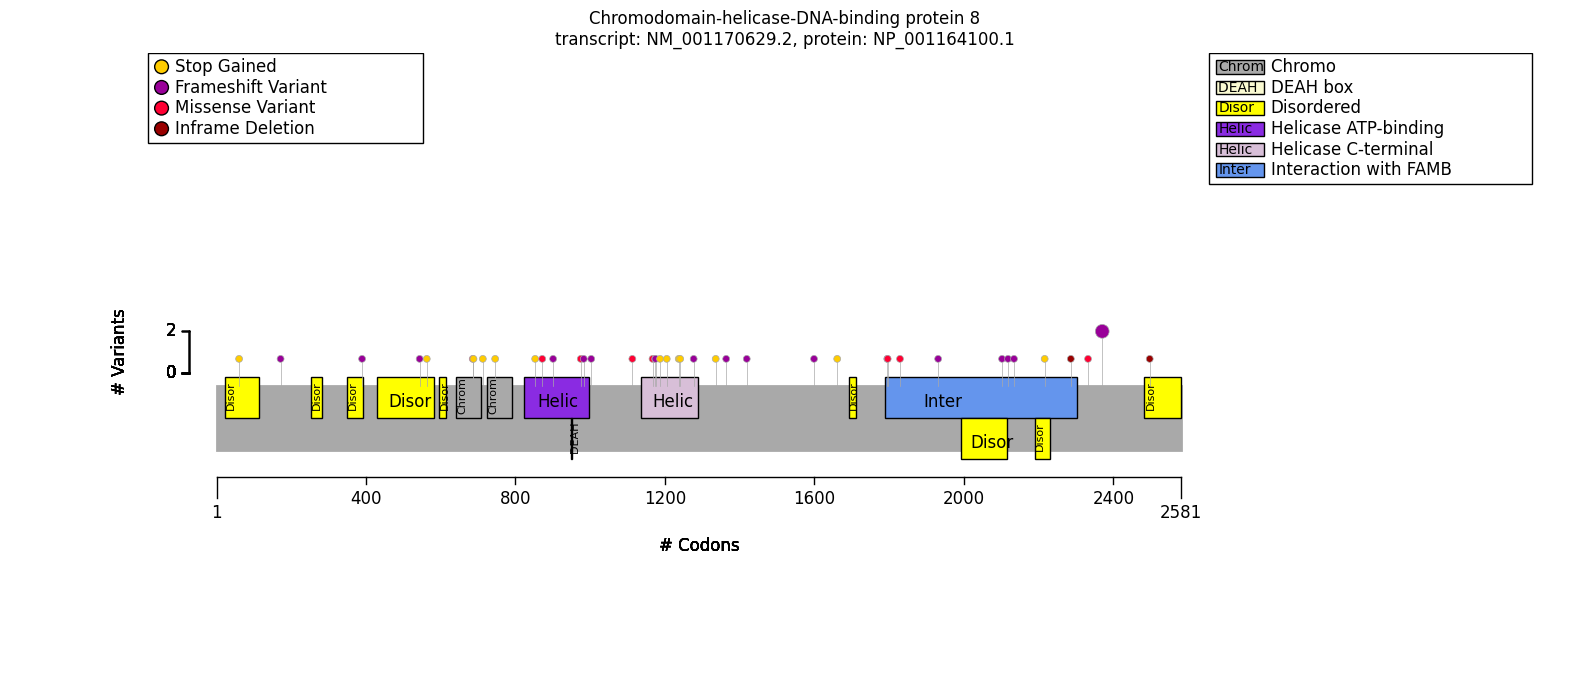

In [6]:
drawer = ProteinVisualizer()
drawer.draw_fig(pvis=pvis);

## Correlation Analysis

In [7]:
from gpsea.analysis.mtc_filter import HpoMtcFilter
mtc_filter = HpoMtcFilter.default_filter(
    hpo=hpo,
    term_frequency_threshold=0.2,
)
mtc_correction = 'fdr_bh'
mtc_alpha = 0.05

In [8]:
from gpsea.analysis.pcats.stats import FisherExactTest

count_statistic = FisherExactTest()

In [9]:
from gpsea.analysis.pcats import HpoTermAnalysis

analysis = HpoTermAnalysis(
    count_statistic=count_statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,
    mtc_alpha=mtc_alpha,
)

In [10]:
from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest

pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
    missing_implies_excluded=False,
    min_n_of_patients_with_term=2,
)

In [11]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate.genotype import VariantPredicates, monoallelic_predicate

is_missense = VariantPredicates.variant_effect(VariantEffect.MISSENSE_VARIANT, CHD8_MANE_transcript)
gt_predicate = monoallelic_predicate(a_predicate=is_missense, b_predicate=~is_missense, names=("Missense", "Not Missense"))


In [12]:
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)

In [13]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo, result)

Allele group                                       Missense          \
                                                      Count Percent   
Overweight [HP:0025502]                                 2/4     50%   
Tall stature [HP:0000098]                               2/7     29%   
Diarrhea [HP:0002014]                                   2/3     67%   
Intellectual disability, borderline [HP:0006889]        2/6     33%   
Pes planus [HP:0001763]                                 2/4     50%   
Seizure [HP:0001250]                                    0/3      0%   
Constipation [HP:0002019]                               3/4     75%   
Hypotonia [HP:0001252]                                  0/5      0%   
Macrocephaly [HP:0000256]                               2/7     29%   
Tall chin [HP:0400000]                                  1/1    100%   
Psychosis [HP:0000709]                                  1/5     20%   
Attention deficit hyperactivity disorder [HP:00...      0/5      0%   
Sleep onset insomnia [HP:0031354]                       2/3     67%   
Autism [HP:0000717]                                     4/6     67%   
Intellectual disability, mild [HP:0001256]              3/7     43%   
Motor delay [HP:0001270]                                2/2    100%   
Delayed speech and language development [HP:000...      3/3    100%   
Downslanted palpebral fissures [HP:0000494]             1/2     50%   
Prominent supraorbital ridges [HP:0000336]              4/6     67%   
Anxiety [HP:0000739]                                    1/4     25%   
Developmental regression [HP:0002376]                   1/3     33%   
Hypertelorism [HP:0000316]                              2/3     67%   
Hypothyroidism [HP:0000821]                             0/1      0%   
Hyperbilirubinemia [HP:0002904]                         0/1      0%   
Self-injurious behavior [HP:0100716]                    1/2     50%   
Intellectual disability, moderate [HP:0002342]          2/7     29%   
Macrotia [HP:0000400]                                   1/3     33%   
Caesarian section [HP:0011410]                          0/1      0%   
Reduced social reciprocity [HP:0012760]                 0/1      0%   
Ventriculomegaly [HP:0002119]                           0/1      0%   
Heterotropia [HP:0032012]                               0/1      0%   

Allele group                                       Not Missense          \
                                                          Count Percent   
Overweight [HP:0025502]                                    1/16      6%   
Tall stature [HP:0000098]                                 20/31     65%   
Diarrhea [HP:0002014]                                      2/14     14%   
Intellectual disability, borderline [HP:0006889]           3/31     10%   
Pes planus [HP:0001763]                                    2/15     13%   
Seizure [HP:0001250]                                       8/15     53%   
Constipation [HP:0002019]                                  9/24     38%   
Hypotonia [HP:0001252]                                     9/34     26%   
Macrocephaly [HP:0000256]                                 19/39     49%   
Tall chin [HP:0400000]                                      2/6     33%   
Psychosis [HP:0000709]                                     2/21     10%   
Attention deficit hyperactivity disorder [HP:00...         7/28     25%   
Sleep onset insomnia [HP:0031354]                          9/21     43%   
Autism [HP:0000717]                                       29/37     78%   
Intellectual disability, mild [HP:0001256]                11/37     30%   
Motor delay [HP:0001270]                                  13/16     81%   
Delayed speech and language development [HP:000...        12/14     86%   
Downslanted palpebral fissures [HP:0000494]                7/13     54%   
Prominent supraorbital ridges [HP:0000336]                25/34     74%   
Anxiety [HP:0000739]                                      10/26     38%   
Develo

In [25]:
from gpsea.analysis.pscore import DeVriesPhenotypeScorer, PhenotypeScoreAnalysis
from gpsea.analysis.pscore.stats import MannWhitneyStatistic

dv_scorer = DeVriesPhenotypeScorer(hpo)
mw_stats = MannWhitneyStatistic()

score_analysis = PhenotypeScoreAnalysis(mw_stats)
score_results = score_analysis.compare_genotype_vs_phenotype_score(cohort, gt_predicate, dv_scorer)

In [21]:
score_results.pval

0.09003329058179307

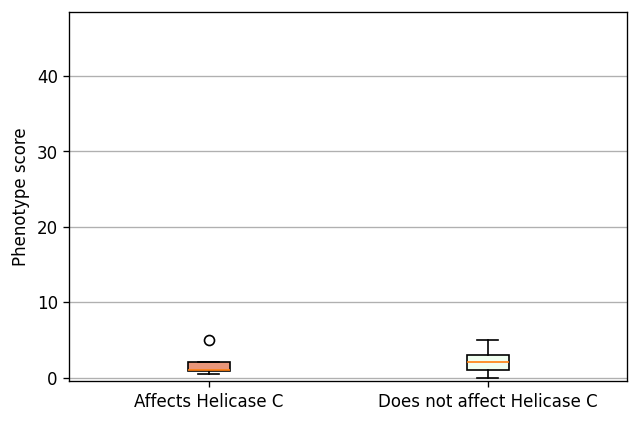

In [24]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6, 4), dpi=120)
score_results.plot_boxplots(
    gt_predicate=gt_predicate,
    ax=ax,
)
_ = ax.grid(axis="y")
_ = ax.set(
    ylabel="Phenotype score", ylim=(-0.5, len(score_results.genotype_phenotype_scores) + 0.5)
)



In [20]:
score_results.genotype_phenotype_scores

,genotype,phenotype
patient_id,,
case report[PMID_32309624_case_report],1,2
Patient 2[PMID_38441608_Patient_2],1,0
patient 16[PMID_31721432_patient_16],1,4
Patient 3[PMID_38441608_Patient_3],1,2
Patient NijmegenDNA-010878[PMID_24998929_Patient_NijmegenDNA_010878],1,1.5
individual 3-DDD-OXF273385[PMID_31001818_individual_3_DDD_OXF273385],0,2
patient 10[PMID_31721432_patient_10],0,1
Patient NijmgenDNA023486[PMID_24998929_Patient_NijmgenDNA023486],1,1
Patient NijmegenDNA07-06646[PMID_24998929_Patient_NijmegenDNA07_06646],0,0.5


In [26]:
from gpsea.analysis.predicate.genotype import ProteinPredicates

prot_pred = ProteinPredicates(pms)
in_helicaseC = prot_pred.protein_feature("Helicase C-terminal", CHD8_MANE_transcript)
gt_predicate = monoallelic_predicate(a_predicate=in_helicaseC, b_predicate=~in_helicaseC, names=("Affects Helicase C", "Does not affect Helicase C"))


In [27]:
result_heli = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)

summarize_hpo_analysis(hpo, result_heli)

Allele group                                       Affects Helicase C          \
                                                                Count Percent   
Downslanted palpebral fissures [HP:0000494]                       0/2      0%   
Psychosis [HP:0000709]                                            1/2     50%   
Intellectual disability, severe [HP:0010864]                      2/8     25%   
Anxiety [HP:0000739]                                              3/5     60%   
Prominent supraorbital ridges [HP:0000336]                        4/7     57%   
Intellectual disability, mild [HP:0001256]                        1/8     12%   
Intellectual disability, moderate [HP:0002342]                    4/8     50%   
Delayed speech and language development [HP:000...                3/4     75%   
Caesarian section [HP:0011410]                                    0/3      0%   
Macrotia [HP:0000400]                                             2/3     67%   
Heterotropia [HP:0032012]                                         0/3      0%   
Self-injurious behavior [HP:0100716]                              2/3     67%   
Ventriculomegaly [HP:0002119]                                     2/5     40%   
Macrocephaly [HP:0000256]                                         4/7     57%   
Motor delay [HP:0001270]                                          4/4    100%   
Autism [HP:0000717]                                               6/7     86%   
Hypotonia [HP:0001252]                                            1/4     25%   
Tall stature [HP:0000098]                                         4/6     67%   
Attention deficit hyperactivity disorder [HP:00...                1/4     25%   
Sleep onset insomnia [HP:0031354]                                 1/3     33%   
Developmental regression [HP:0002376]                             2/3     67%   
Constipation [HP:0002019]                                         1/3     33%   
Hypertelorism [HP:0000316]                                        2/4     50%   
Diarrhea [HP:0002014]                                             0/1      0%   
Pes planus [HP:0001763]                                           0/1      0%   
Polyhydramnios [HP:0001561]                                       0/1      0%   
Hypothyroidism [HP:0000821]                                       0/2      0%   
Hyperbilirubinemia [HP:0002904]                                   0/2      0%   
Seizure [HP:0001250]                                              1/3     33%   
Reduced social reciprocity [HP:0012760]                           0/2      0%   
Tall chin [HP:0400000]                                            1/2     50%   

Allele group                                       Does not affect Helicase C  \
                                                                        Count   
Downslanted palpebral fissures [HP:0000494]                              8/13   
Psychosis [HP:0000709]                                                   2/24   
Intellectual disability, severe [HP:0010864]                             4/35   
Anxiety [HP:0000739]                                                     8/25   
Prominent supraorbital ridges [HP:0000336]                              25/33   
Intellectual disability, mild [HP:0001256]                              13/36   
Intellectual disability, moderate [HP:0002342]                          10/35   
Delayed speech and language development [HP:000...                      12/13   
Caesarian section [HP:0011410]                                            4/9   
Macrotia [HP:0000400]                                                    3/11   
Heterotropia [HP:0032012]                                                3/10   
Self-injurious behavior [HP:0100716]                                      3/8   
Ventriculomegaly [HP:0002119]                                            2/11   
Macrocephaly [HP:0000256]                                               17/39   
Motor delay [HP:0001270]      

In [28]:
score_results_heli = score_analysis.compare_genotype_vs_phenotype_score(cohort, gt_predicate, dv_scorer)

In [29]:
score_results_heli.pval

0.1542854677653526

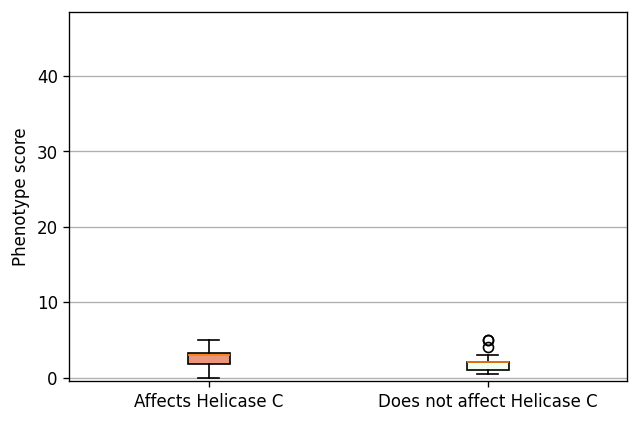

In [32]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=120)
score_results_heli.plot_boxplots(
    gt_predicate=gt_predicate,
    ax=ax,
)
_ = ax.grid(axis="y")
_ = ax.set(
    ylabel="Phenotype score", ylim=(-0.5, len(score_results.genotype_phenotype_scores) + 0.5)
)